In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
import os
import base64
import time
from dotenv import load_dotenv
from collections import OrderedDict
from datetime import date, timedelta

In [2]:
start_date = date(2022, 1, 1)
end_date = date(2024, 8, 8)

current_date = start_date
billboard_dfs = []
while(current_date <= end_date):
    current_csv = f"{current_date.strftime('%Y-%m-%d')}.csv"
    billboard_data = requests.get(f"https://raw.githubusercontent.com/utdata/rwd-billboard-data/main/data-scraped/hot-100/{current_date.year}/{current_csv}").content
    print(f"Fetched {current_csv}")
    
    current_billboard_df = pd.read_csv(io.StringIO(billboard_data.decode("utf-8"))).loc[:9]
    billboard_dfs.append(current_billboard_df)
    current_date += timedelta(days=7)

Fetched 2022-01-01.csv
Fetched 2022-01-08.csv
Fetched 2022-01-15.csv
Fetched 2022-01-22.csv
Fetched 2022-01-29.csv
Fetched 2022-02-05.csv
Fetched 2022-02-12.csv
Fetched 2022-02-19.csv
Fetched 2022-02-26.csv
Fetched 2022-03-05.csv
Fetched 2022-03-12.csv
Fetched 2022-03-19.csv
Fetched 2022-03-26.csv
Fetched 2022-04-02.csv
Fetched 2022-04-09.csv
Fetched 2022-04-16.csv
Fetched 2022-04-23.csv
Fetched 2022-04-30.csv
Fetched 2022-05-07.csv
Fetched 2022-05-14.csv
Fetched 2022-05-21.csv
Fetched 2022-05-28.csv
Fetched 2022-06-04.csv
Fetched 2022-06-11.csv
Fetched 2022-06-18.csv
Fetched 2022-06-25.csv
Fetched 2022-07-02.csv
Fetched 2022-07-09.csv
Fetched 2022-07-16.csv
Fetched 2022-07-23.csv
Fetched 2022-07-30.csv
Fetched 2022-08-06.csv
Fetched 2022-08-13.csv
Fetched 2022-08-20.csv
Fetched 2022-08-27.csv
Fetched 2022-09-03.csv
Fetched 2022-09-10.csv
Fetched 2022-09-17.csv
Fetched 2022-09-24.csv
Fetched 2022-10-01.csv
Fetched 2022-10-08.csv
Fetched 2022-10-15.csv
Fetched 2022-10-22.csv
Fetched 202

In [3]:
billboard_df = pd.concat(billboard_dfs).reset_index()[["chart_week", "current_week", "title", "performer"]]
billboard_df["chart_week"] = pd.to_datetime(billboard_df["chart_week"])
billboard_df

,chart_week,current_week,title,performer
0,2022-01-01,1,All I Want For Christmas Is You,Mariah Carey
1,2022-01-01,2,Rockin' Around The Christmas Tree,Brenda Lee
2,2022-01-01,3,Jingle Bell Rock,Bobby Helms
3,2022-01-01,4,A Holly Jolly Christmas,Burl Ives
4,2022-01-01,5,Easy On Me,Adele
...,...,...,...,...
1355,2024-08-03,6,Too Sweet,Hozier
1356,2024-08-03,7,Please Please Please,Sabrina Carpenter
1357,2024-08-03,8,Lose Control,Teddy Swims
1358,2024-08-03,9,Beautiful Things,Benson Boone


In [25]:
load_dotenv()
client_id = os.getenv("SPOTIFY_CLIENT_ID")
client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")

credentials = f"{client_id}:{client_secret}"
base64_credentials = base64.b64encode(credentials.encode()).decode()

auth_options = {
    "headers": {"Authorization": f"Basic {base64_credentials}"},
    "data": {"grant_type": "client_credentials"}
}
auth_response = requests.post("https://accounts.spotify.com/api/token", headers=auth_options["headers"], data=auth_options["data"]).json()
access_token = auth_response["access_token"]
access_token

'BQCtbrVI0YWuizysmlXN6EPlonKnyEqMq6NE5lKYOXIbAL2jolowUyYgG0WySKbSF71f1ae-5rgrynxgvkNVwbABSFkSruCDQ58buHcHHMnWktrxvI8'

In [5]:
def parse_artist(artist):
    return artist.split("X")[0].split("&")[0].split(",")[0].split("Featuring")[0].strip()

def parse_song_name(name):
    if "*" in name:
        words = name.split(" ")
        replaced_words = []
        for word in words:
            if "*" in word:
                new_word = word[0] + "*" * (len(word) - 1)
                replaced_words.append(new_word)
            else:
                replaced_words.append(word)
        return " ".join(replaced_words)
    return name

In [41]:
track_info = OrderedDict()

def find_track_id(song):
    name = parse_song_name(song["title"])
    artist = parse_artist(song["performer"])

    if((name, artist) not in track_info):
        while True:
            search_response = requests.get(
                "https://api.spotify.com/v1/search",
                headers={"Authorization": f"Bearer {access_token}"},
                params={
                    "q":  f"{name} {artist}",
                    "type": "track",
                    "limit": 1
                }
            )
            if search_response.status_code == 429:
                print("Too many requests. Retrying in 30 seconds...")
                time.sleep(30)
            else:
                try:
                    track_id = search_response.json()["tracks"]["items"][0]["id"]
                    artist_id = search_response.json()["tracks"]["items"][0]["artists"][0]["id"]
                    track_info[(name, artist)] = {"track_id": track_id, "artist_id": artist_id}
                    print(f"Id for '{name}' by '{artist}' is {track_id}")
                except:
                    print(f"Error in '{name}' by '{artist}'")
                    print(search_response.json())
                break

billboard_df.apply(find_track_id, axis=1)
print(f"Total number of track ids found: {len(track_info)}")

Id for 'All I Want For Christmas Is You' by 'Mariah Carey' is 0bYg9bo50gSsH3LtXe2SQn
Id for 'Rockin' Around The Christmas Tree' by 'Brenda Lee' is 2EjXfH91m7f8HiJN1yQg97
Id for 'Jingle Bell Rock' by 'Bobby Helms' is 7vQbuQcyTflfCIOu3Uzzya
Id for 'A Holly Jolly Christmas' by 'Burl Ives' is 77khP2fIVhSW23NwxrRluh
Id for 'Easy On Me' by 'Adele' is 0gplL1WMoJ6iYaPgMCL0gX
Id for 'It's The Most Wonderful Time Of The Year' by 'Andy Williams' is 5hslUAKq9I9CG2bAulFkHN
Id for 'Last Christmas' by 'Wham!' is 2FRnf9qhLbvw8fu4IBXx78
Id for 'Feliz Navidad' by 'Jose Feliciano' is 0oPdaY4dXtc3ZsaG17V972
Id for 'Stay' by 'The Kid LAROI' is 567e29TDzLwZwfDuEpGTwo
Id for 'Sleigh Ride' by 'The Ronettes' is 7fUYUcWy853HS8YJn0b3Sr
Id for 'Heat Waves' by 'Glass Animals' is 3USxtqRwSYz57Ewm6wWRMp
Id for 'Shivers' by 'Ed Sheeran' is 50nfwKoDiSYg8zOCREWAm5
Id for 'We Don't Talk About Bruno' by 'Carolina Gaitan' is 52xJxFP6TqMuO4Yt0eOkMz
Id for 'Industry Baby' by 'Lil Nas' is 27NovPIUIRrOZoCHxABJwK
Id for 'Cold 

In [42]:
track_ids = [x["track_id"] for x in track_info.values()]
audio_features = []
for i in range(0, len(track_ids), 100):
    chunk = track_ids[i:i + 100]

    while True:
        audio_features_response = requests.get(
            "https://api.spotify.com/v1/audio-features",
            headers={"Authorization": f"Bearer {access_token}"},
            params={"ids": ",".join(chunk)}
        )
        if audio_features_response.status_code == 429:
            print("Too many requests. Retrying in 30 seconds...")
            time.sleep(30)
        else:
            print(f"Fetched audio features for tracks {i+1} to {i+len(chunk)}")
            audio_features += audio_features_response.json()["audio_features"]
            break

artist_ids = [x["artist_id"] for x in track_info.values()]
genres = []
for i in range(0, len(artist_ids), 50):
    chunk = artist_ids[i:i + 50]

    while True:
        artist_response = requests.get(
            "https://api.spotify.com/v1/artists",
            headers={"Authorization": f"Bearer {access_token}"},
            params={"ids": ",".join(chunk)}
        )
        if artist_response.status_code == 429:
            print("Too many requests. Retrying in 30 seconds...")
            time.sleep(30)
        else:
            print(f"Fetched artists {i+1} to {i+len(chunk)}")
            genres += [x["genres"] for x in artist_response.json()["artists"]]
            break

for i, k in enumerate(track_info.keys()):
    track_info[k] = audio_features[i]
    track_info[k]["genres"] = genres[i]

print(f"Features found: {', '.join(next(iter(track_info.values())).keys())}")

Fetched audio features for tracks 1 to 100
Fetched audio features for tracks 101 to 200
Fetched audio features for tracks 201 to 205
Fetched artists 1 to 50
Fetched artists 51 to 100
Fetched artists 101 to 150
Fetched artists 151 to 200
Fetched artists 201 to 205
Features found: danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, type, id, uri, track_href, analysis_url, duration_ms, time_signature, genres


In [43]:
def add_feature(song, feature):
    name = parse_song_name(song["title"])
    artist = parse_artist(song["performer"])
    return track_info[(name, artist)][feature] if (name, artist) in track_info else None

billboard_df["danceability"] = billboard_df.apply(add_feature, args=("danceability",), axis=1)
billboard_df["energy"] = billboard_df.apply(add_feature, args=("energy",), axis=1)
billboard_df["loudness"] = billboard_df.apply(add_feature, args=("loudness",), axis=1)
billboard_df["speechiness"] = billboard_df.apply(add_feature, args=("speechiness",), axis=1)
billboard_df["acousticness"] = billboard_df.apply(add_feature, args=("acousticness",), axis=1)
billboard_df["liveness"] = billboard_df.apply(add_feature, args=("liveness",), axis=1)
billboard_df["tempo"] = billboard_df.apply(add_feature, args=("tempo",), axis=1)
billboard_df["valence"] = billboard_df.apply(add_feature, args=("valence",), axis=1)
billboard_df["time_signature"] = billboard_df.apply(add_feature, args=("time_signature",), axis=1)
billboard_df["duration_ms"] = billboard_df.apply(add_feature, args=("duration_ms",), axis=1)
billboard_df["genres"] = billboard_df.apply(add_feature, args=("genres",), axis=1)

billboard_df

,chart_week,current_week,title,performer,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,valence,time_signature,duration_ms,genres
0,2022-01-01,1,All I Want For Christmas Is You,Mariah Carey,0.336,0.627,-7.463,0.0384,0.1640,0.0708,150.273,0.350,4,241107,"[dance pop, pop, urban contemporary]"
1,2022-01-01,2,Rockin' Around The Christmas Tree,Brenda Lee,0.598,0.470,-8.744,0.0496,0.6170,0.5050,67.086,0.879,4,126267,"[adult standards, lounge, rockabilly]"
2,2022-01-01,3,Jingle Bell Rock,Bobby Helms,0.754,0.424,-8.463,0.0363,0.6430,0.0652,119.705,0.806,4,130973,[]
3,2022-01-01,4,A Holly Jolly Christmas,Burl Ives,0.682,0.375,-13.056,0.0303,0.5790,0.0760,140.453,0.888,4,135533,"[adult standards, american folk revival]"
4,2022-01-01,5,Easy On Me,Adele,0.604,0.366,-7.519,0.0282,0.5780,0.1330,141.981,0.130,4,224695,"[british soul, pop, pop soul, uk pop]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,2024-08-03,6,Too Sweet,Hozier,0.741,0.620,-5.505,0.0412,0.0295,0.0398,117.038,0.934,4,251424,"[irish singer-songwriter, modern rock, pop, po..."
1356,2024-08-03,7,Please Please Please,Sabrina Carpenter,0.669,0.586,-6.073,0.0540,0.2740,0.1040,107.071,0.579,4,186365,[pop]
1357,2024-08-03,8,Lose Control,Teddy Swims,0.561,0.604,-4.409,0.0337,0.1990,0.1040,159.920,0.242,3,210689,[]
1358,2024-08-03,9,Beautiful Things,Benson Boone,0.472,0.471,-5.692,0.0603,0.1510,0.1400,105.029,0.219,3,180304,[singer-songwriter pop]


In [44]:
billboard_df.to_csv("billboard.csv", index=False)

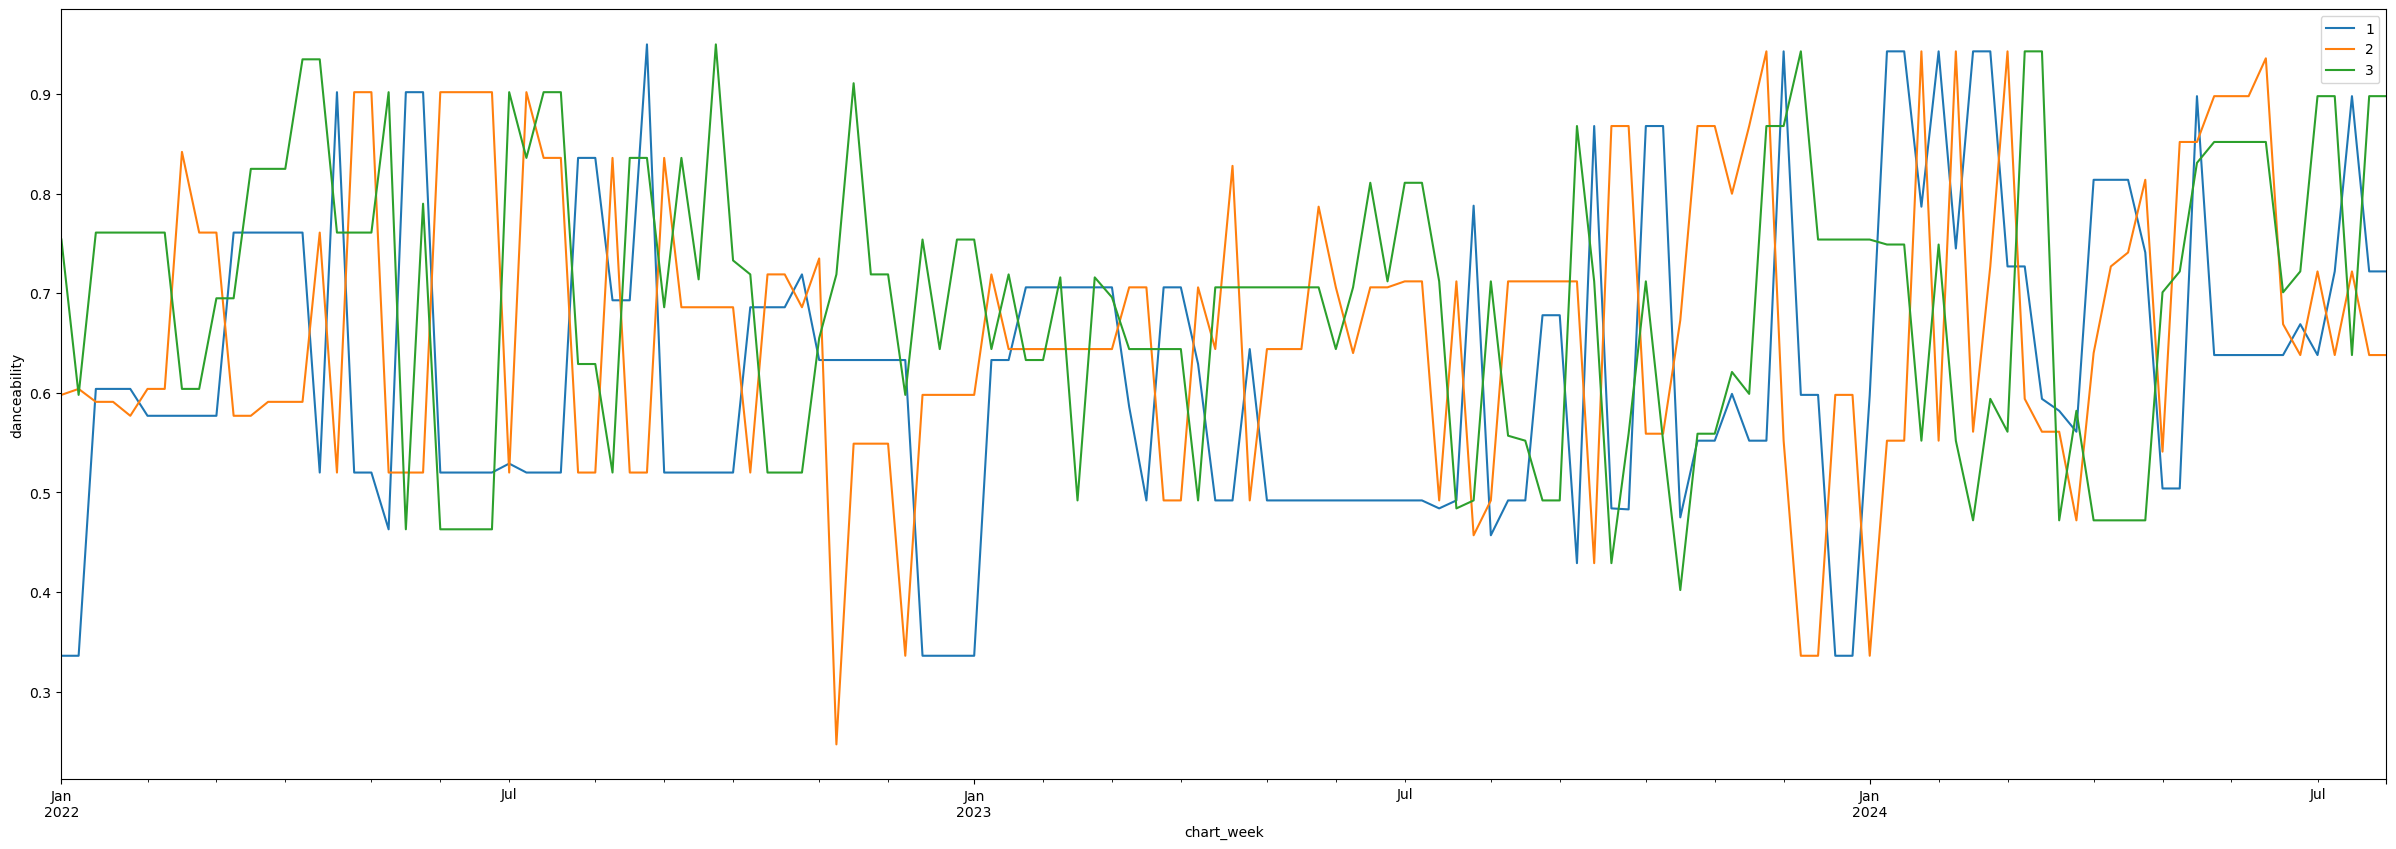

In [23]:
billboard_fig = plt.figure(figsize=(30, 10))
for i in range(1, 4):
    df = billboard_df.loc[billboard_df["current_week"] == i].set_index("chart_week")
    df["danceability"].plot(label=i, ylabel="danceability")
    
plt.legend()
plt.show()

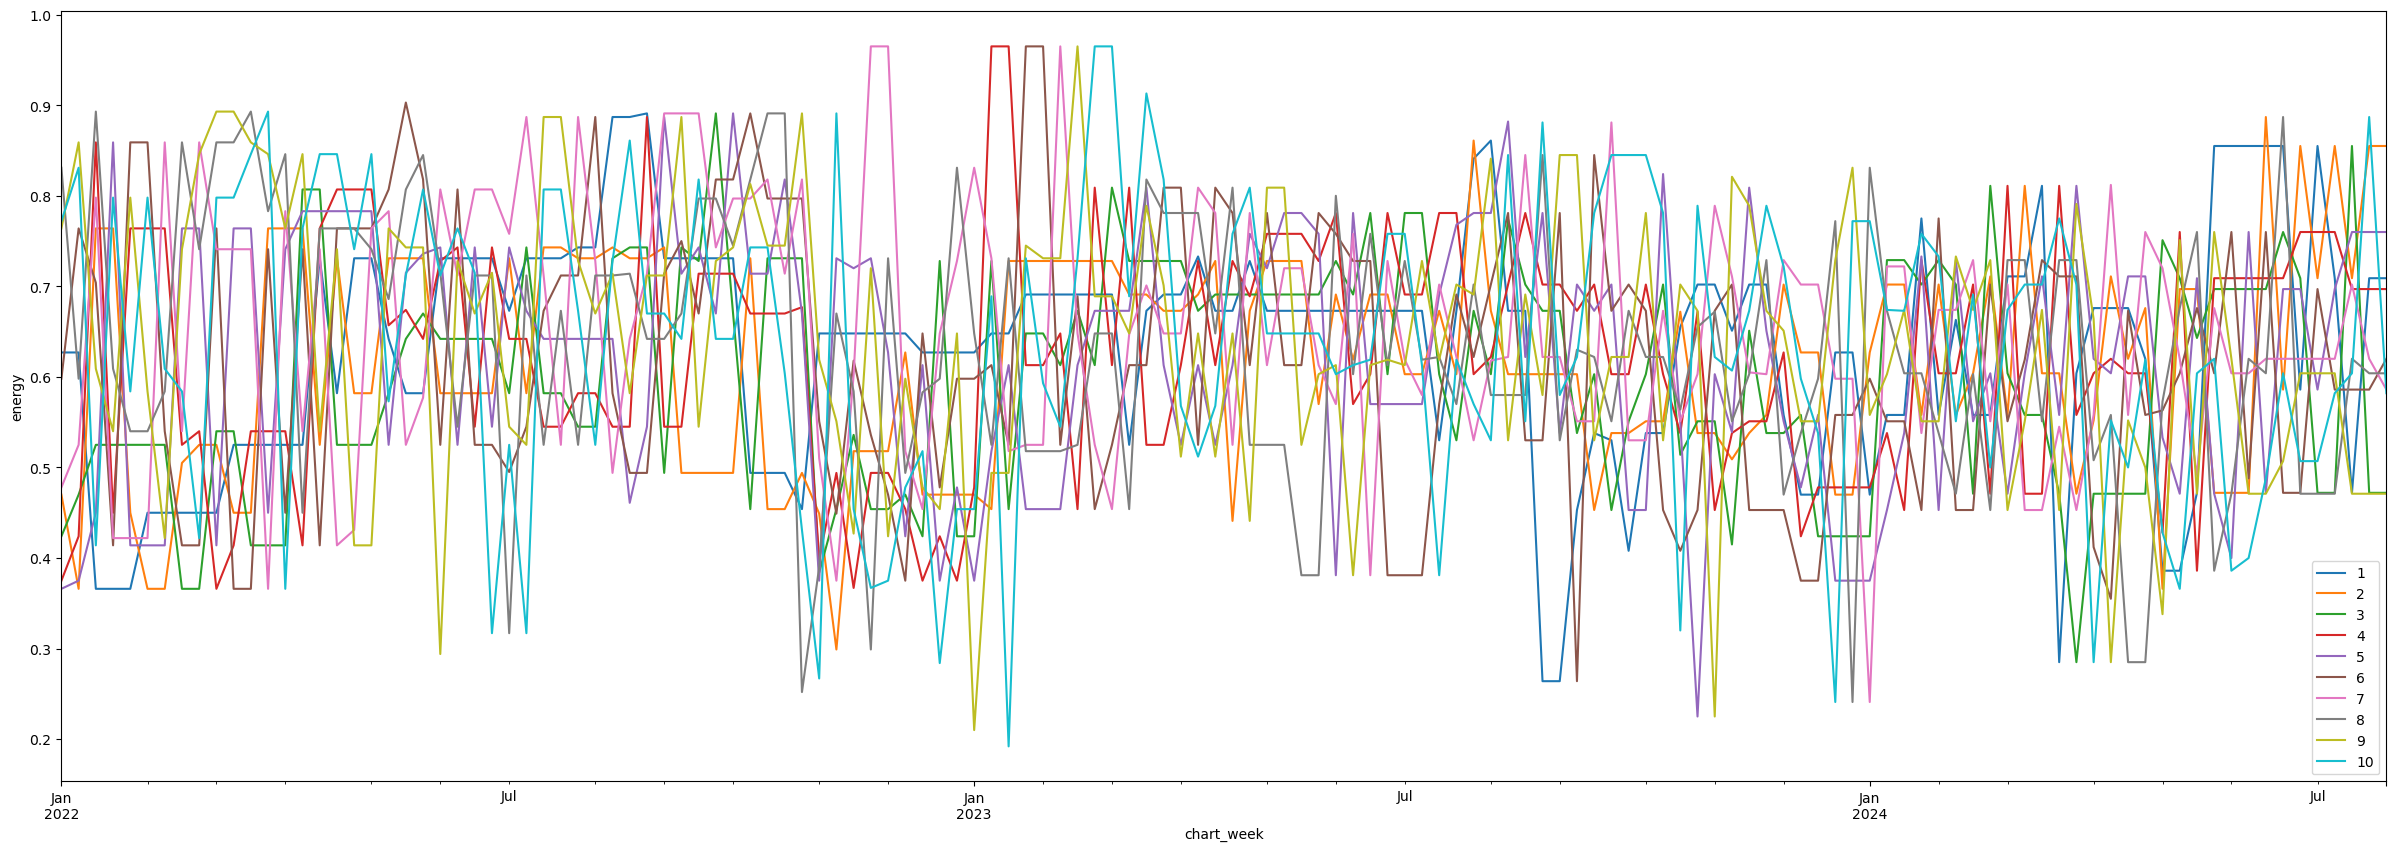

In [22]:
billboard_fig = plt.figure(figsize=(30, 10))
for i in range(1, 11):
    df = billboard_df.loc[billboard_df["current_week"] == i].set_index("chart_week")
    df["energy"].plot(label=i, ylabel="energy")
    
plt.legend()
plt.show()

In [14]:
gpr_data = requests.get("https://www.matteoiacoviello.com/gpr_files/data_gpr_daily_recent.xls").content

gpr_df = pd.DataFrame(pd.read_excel(io.BytesIO(gpr_data), index_col="date", parse_dates=True)) 
gpr_df = gpr_df.loc["2022-01-01":][["GPRD", "GPRD_THREAT", "GPRD_ACT"]]
gpr_df

,GPRD,GPRD_THREAT,GPRD_ACT
date,,,
2022-01-01,63.096531,91.816795,31.451157
2022-01-02,37.857918,62.960087,0.000000
2022-01-03,52.343060,74.614098,14.909126
2022-01-04,88.963112,139.248215,10.434032
2022-01-05,96.482552,137.534164,82.444771
...,...,...,...
2024-08-01,139.343185,168.535599,164.171432
2024-08-02,195.215775,192.764542,279.758881
2024-08-03,106.857018,71.083969,142.037476


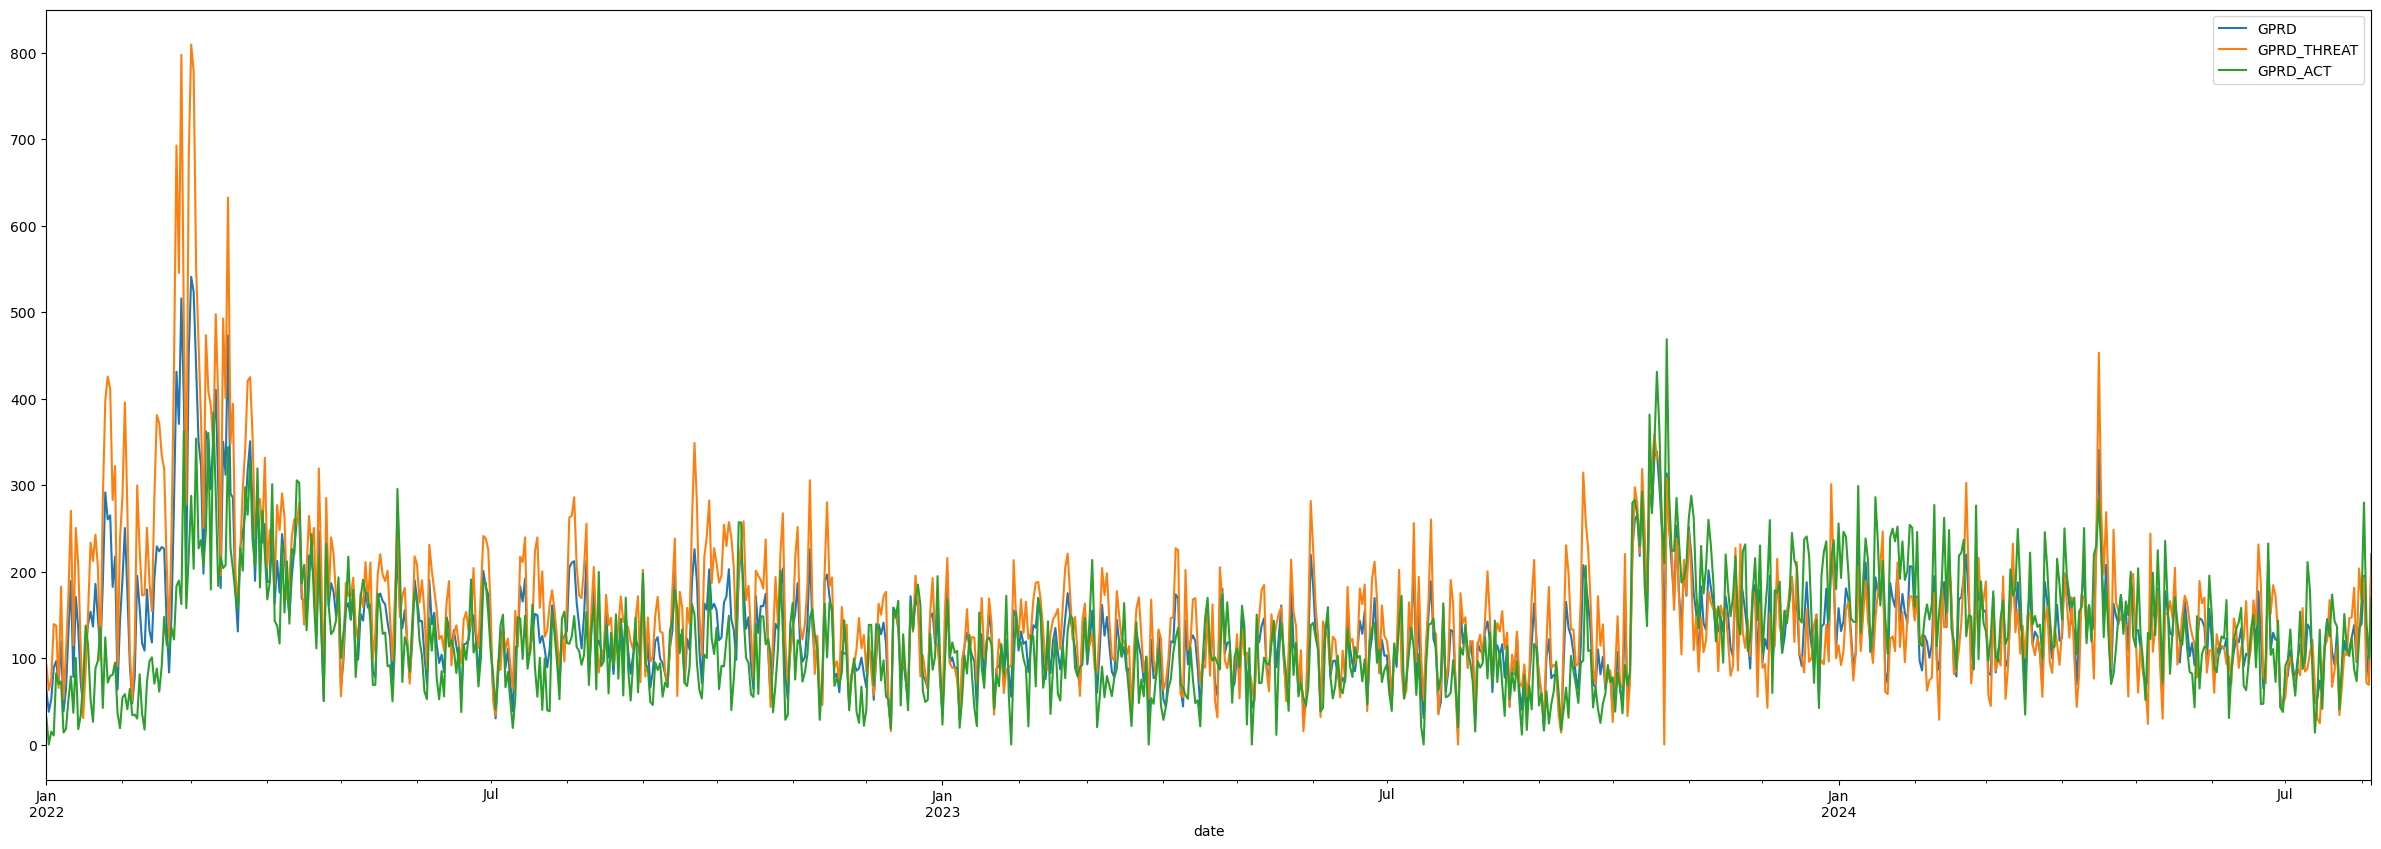

In [15]:
gpr_fig = plt.figure(figsize=(30, 10))
gpr_df["GPRD"].plot()
gpr_df["GPRD_THREAT"].plot()
gpr_df["GPRD_ACT"].plot()

plt.legend()
plt.show()